In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd

# path = r"C:\Users\LENOVO\OneDrive\Pictures\Documents\GitHub\CBL-SIAB\data\BBCA.JK_extended.csv"
# df = pd.read_csv(path)

from google.colab import files
uploaded = files.upload()
df = pd.read_csv("BBCA.JK_extended.csv")


df.head()


Saving BBCA.JK_extended.csv to BBCA.JK_extended.csv


,Date,Open,High,Low,Close,Volume
0,2014-12-08 00:00:00+00:00,2655.0,2680.0,2645.0,2655.0,37435500
1,2014-12-09 00:00:00+00:00,2660.0,2680.0,2630.0,2650.0,38254000
2,2014-12-10 00:00:00+00:00,2630.0,2675.0,2630.0,2660.0,32998000
3,2014-12-11 00:00:00+00:00,2660.0,2675.0,2645.0,2655.0,54459500
4,2014-12-12 00:00:00+00:00,2640.0,2665.0,2640.0,2650.0,50302000


In [3]:
import pandas as pd
import numpy as np

# pilih kolom yang dipakai
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

In [4]:
df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


In [5]:
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64


In [8]:
threshold = 0.003  # 0.3%

df['Return'] = (df['Close'].shift(-1) - df['Close']) / df['Close']

df['Label'] = np.where(df['Return'] > threshold, 1, 0)
df = df[:-1]


In [9]:
label_dist = df['Label'].value_counts().rename(index={1:'Naik', 0:'Turun'})
label_percent = (df['Label'].value_counts(normalize=True) * 100).rename(index={1:'Naik', 0:'Turun'})

pd.DataFrame({
    'Jumlah Data': label_dist,
    'Persentase (%)': label_percent.round(2)
})

,Jumlah Data,Persentase (%)
Label,,
Turun,1714,62.88
Naik,1012,37.12


In [10]:
# Moving Average 5 hari
df['MA5'] = df['Close'].rolling(window=5).mean()

# Moving Average 10 hari
df['MA10'] = df['Close'].rolling(window=10).mean()


In [11]:
df = df.dropna().reset_index(drop=True)

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,Return,Label,MA5,MA10
0,2014-12-19,2630.0,2650.0,2620.0,2635.0,83389500,-0.007590,0,2596.0,2625.0
1,2014-12-22,2650.0,2650.0,2615.0,2615.0,33301000,0.005736,1,2597.0,2621.0
2,2014-12-23,2640.0,2640.0,2625.0,2630.0,21132000,0.003802,1,2609.0,2619.0
3,2014-12-24,2650.0,2655.0,2635.0,2640.0,19135500,-0.003788,0,2623.0,2617.0
4,2014-12-29,2630.0,2650.0,2625.0,2630.0,24315000,-0.001901,0,2630.0,2614.5


In [13]:
X = df[
    [
        'Open',
        'High',
        'Low',
        'Close',
        'Volume',
        'MA5',
        'MA10',
    ]
]

y = df['Label']


In [14]:
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [15]:
print("Total data :", len(df))
print("Train data :", len(X_train))
print("Test data  :", len(X_test))


Total data : 2717
Train data : 2173
Test data  : 544


In [16]:
pip install xgboost


In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
import joblib

# Save the trained model to a .pkl file
joblib.dump(model, 'siab_model.pkl')
print("Model saved as siab_model.pkl")

Model saved as siab_model.pkl


You can now find the `xgboost_model.pkl` file in your Colab environment. If you want to download it, you can use the following code:

In [24]:
from google.colab import files
files.download('siab_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

=== HASIL DATA TRAIN ===
Akurasi (Train): 0.8182236539346526
Confusion Matrix (Train):
 [[1329   28]
 [ 367  449]]
              precision    recall  f1-score   support

       Turun       0.78      0.98      0.87      1357
        Naik       0.94      0.55      0.69       816

    accuracy                           0.82      2173
   macro avg       0.86      0.76      0.78      2173
weighted avg       0.84      0.82      0.80      2173



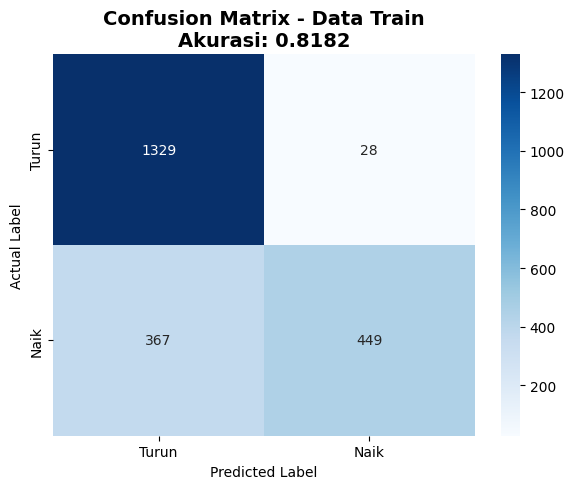

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Prediksi data train
y_train_pred = model.predict(X_train)

# Hitung akurasi
train_accuracy = accuracy_score(y_train, y_train_pred)

print("=== HASIL DATA TRAIN ===")
print("Akurasi (Train):", train_accuracy)
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred, target_names=['Turun','Naik']))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_train,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Turun', 'Naik'],
    yticklabels=['Turun', 'Naik']
)

plt.title(f'Confusion Matrix - Data Train\nAkurasi: {train_accuracy:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


=== HASIL DATA TEST ===
Akurasi (Test): 0.6268382352941176
Confusion Matrix (Test):
 [[305  46]
 [157  36]]
              precision    recall  f1-score   support

       Turun       0.66      0.87      0.75       351
        Naik       0.44      0.19      0.26       193

    accuracy                           0.63       544
   macro avg       0.55      0.53      0.51       544
weighted avg       0.58      0.63      0.58       544



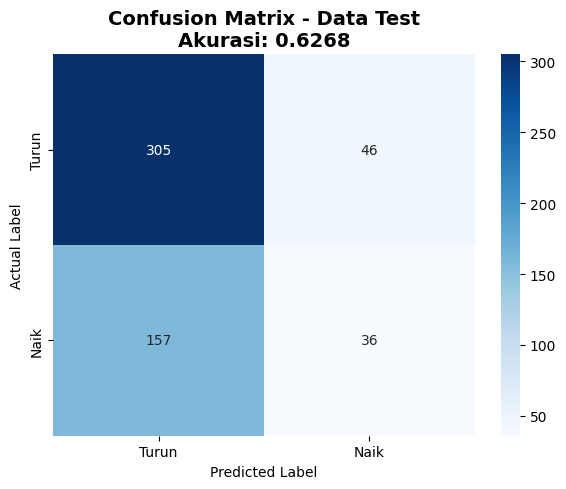

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Prediksi data test
y_test_pred = model.predict(X_test)

# Hitung akurasi
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=== HASIL DATA TEST ===")
print("Akurasi (Test):", test_accuracy)
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, target_names=['Turun','Naik']))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# Visualisasi
plt.figure(figsize=(6,5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Turun', 'Naik'],
    yticklabels=['Turun', 'Naik']
)

plt.title(f'Confusion Matrix - Data Test\nAkurasi: {test_accuracy:.4f}',
          fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()


In [20]:
print(np.unique(y_train_pred, return_counts=True))
print(np.unique(y_test_pred, return_counts=True))


(array([0, 1]), array([1696,  477]))
(array([0, 1]), array([462,  82]))
